# Additional UNET for SOCAT

sources:
https://github.com/dorltcheng/Transfer-Learning-U-Net-Deep-Learning-for-Lung-Ultrasound-Segmentation/blob/main/Model.py



In [1]:
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

import os
tf.random.set_seed(42)


sys.path.insert(0, '../../src')
from utils import df_to_xarray,read_xarray,inverse_scale_image, get_point_prediction, eliminate_zero_pco2

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced,preprocess_images_nfp,preprocess_images

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-03-28 14:37:45.480395: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [51]:
import tensorflow.keras.backend as kb
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    y_pred = y_pred[(y_true != 0) & (y_true != 0.0)]
    y_true = y_true[(y_true != 0) & (y_true != 0.0)]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true),axis= -1))

In [52]:
tf.keras.backend.clear_session()

In [53]:
dir_name="../../data/data1"
val_dir_name="../../data/data2"

data,pco2 = preprocess_images(dir_name)
data_socat, pco2_socat = preprocess_images(dir_name, socat = True)

val_data,val_pco2 = preprocess_images(val_dir_name,"035")
val_data_socat,val_pco2_socat = preprocess_images(val_dir_name,"035",socat=True)

INPUT_SHAPE=data_socat[0].shape
OUTPUT_SHAPE=pco2_socat[0].shape

chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2t = read_xarray(dir_name)
chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2t2 = read_xarray(val_dir_name,num="035")

In [55]:
id1,pco2_1 = eliminate_zero_pco2(pco2t)
pco2_1 = preprocess_image_reduced(pco2_1)
data_socat = data_socat[id1]


id2,pco2_2 = eliminate_zero_pco2(pco2t2)
pco2_2 = preprocess_image_reduced(pco2_2)
data_socat2 = val_data_socat[id2]

pco2_socat=np.vstack([pco2_1,pco2_2])
data_socat=np.vstack([data_socat,data_socat2])
data=np.vstack([data[id1],val_data[id2]])


In [56]:
from tensorflow.keras.layers import Dense, Flatten, Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, LeakyReLU


def tl_unet_socat_model(INPUT_SHAPE,OUTPUT_SHAPE):
    # input: input_shape (height, width, channels) 
    # return model
    input_shape = INPUT_SHAPE
    base_model = tf.keras.models.load_model('../../models/base_model/base_model_new.h5', custom_objects={'custom_rmse':custom_rmse})

    for layer in base_model.layers:
        layer.trainable = False
    #print("base_model")
    #print(base_model.summary())

    # the bridge (exclude the last maxpooling layer in VGG16) 
    bridge = base_model.get_layer("conv2d_3").output
    
    # print("=====================")
    # print("bridge_shape")
    # print(bridge.shape)
    
    
    # Decoder now
    up1 = Conv2DTranspose(128, kernel_size = 5, padding='same')(bridge)

    concat_1 = concatenate([up1, base_model.get_layer("conv2d_2").output], axis=3)

    conv6u = Conv2D(32, kernel_size = 5, activation='relu', padding='same')(concat_1)
    conv6 = Conv2D(32, kernel_size = 5, activation='relu', padding='same')(conv6u)

    up2u = Conv2DTranspose(64,kernel_size=5, padding='same')(conv6)
    up2 = keras.layers.UpSampling2D(size=3)(up2u)
    print("up2")
    print(up2.shape)
    concat_2 = concatenate([up2, base_model.get_layer("conv2d_1").output], axis=3)
    conv7u = Conv2D(16, kernel_size = 5, activation='relu', padding='same')(concat_2)
    conv7 = Conv2D(16, kernel_size = 5, activation='relu', padding='same')(conv7u)

    up3 = Conv2DTranspose(64,kernel_size=5, padding='same')(conv7)
    print("up3")
    print(up3.shape)
    concat_3 = concatenate([up3, base_model.get_layer("conv2d").output], axis=3)
    conv8u = Conv2D(8, kernel_size = 5, activation='relu', padding='same')(concat_3)
    conv8 = Conv2D(8, kernel_size = 5, activation='relu', padding='same')(conv8u)
    
    conv10 = Conv2D(filters=1,kernel_size=1,activation="relu")(conv8)    
    print(conv10.shape)
    
    model_ = keras.models.Model(inputs=[base_model.input], outputs=[conv10])

    return model_


In [58]:
new_model=tl_unet_socat_model(INPUT_SHAPE,OUTPUT_SHAPE)

new_model.summary()

up2
(None, 180, 360, 64)
up3
(None, 180, 360, 64)
(None, 180, 360, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_input (InputLayer)       [(None, 180, 360, 5) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 180, 360, 64) 8064        conv2d_input[0][0]               
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 180, 360, 64) 102464      conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 60, 120, 64)  0           conv2d_1[0][0]                   
______________________

In [59]:
new_model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(learning_rate=1e-4),
)

model_path="../../models/transfer_CNN_new.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 30
batch_size = 32

history = new_model.fit(
    data_socat,
    pco2_socat,
    batch_size=batch_size,
    epochs=epochs,
    workers=-1,
    validation_data=(data_socat, pco2_socat),
    callbacks=callbacks,
)

Epoch 1/30
25/25 [==============================] - 15s 597ms/step - loss: 16.2239 - val_loss: 13.0161
Epoch 2/30
25/25 [==============================] - 12s 486ms/step - loss: 12.7905 - val_loss: 9.2769
Epoch 3/30
25/25 [==============================] - 12s 484ms/step - loss: 9.0926 - val_loss: 6.7271
Epoch 4/30
25/25 [==============================] - 12s 485ms/step - loss: 6.6653 - val_loss: 5.4371
Epoch 5/30
25/25 [==============================] - 12s 485ms/step - loss: 5.4161 - val_loss: 4.3713
Epoch 6/30
25/25 [==============================] - 12s 485ms/step - loss: 4.4924 - val_loss: 3.7038
Epoch 7/30
25/25 [==============================] - 12s 486ms/step - loss: 3.8248 - val_loss: 3.2727
Epoch 8/30
25/25 [==============================] - 12s 485ms/step - loss: 3.5139 - val_loss: 2.9868
Epoch 9/30
25/25 [==============================] - 12s 486ms/step - loss: 3.2172 - val_loss: 2.7979
Epoch 10/30
25/25 [==============================] - 12s 485ms/step - loss: 2.9054 - val

In [60]:
best_model = tf.keras.models.load_model("../../models/transfer_CNN_new.h5", custom_objects={'custom_rmse':custom_rmse})

data_socat_test, pco2_socat = preprocess_images(dir_name, socat = True)
# id1,pco2_1 = eliminate_zero_pco2(pco2t)

# pco2_socat=pco2_socat[id1]
# data_socat_test=data_socat_test[id1]
# predicted_frames=predicted_frames[id1]

pco2_socat=np.expand_dims(pco2_socat, axis=3)

predicted_frames=new_model.predict(data_socat_test,verbose=1)
predicted_frames[pco2_socat==0]=0.0

14/14 [==============================] - 2s 177ms/step


In [61]:
def inverse_scale_image_socat(arr, df):
    """
    inverse_scale_image(arr, df):
    - inverses the pco2 scaling
    """    
    old_min = 0
    old_max = np.nanmax(df)
    y_pred = arr*(old_max-old_min)/255
    
    tmp=np.nan_to_num(df)
    y_true = np.expand_dims(tmp, axis=3)
    y_pred[y_true==0] = 0
    return y_true,y_pred

In [62]:
y_true,y_pred = inverse_scale_image_socat(predicted_frames,pco2t.pCO2_socat.data)  

print("Full RMSE score:")
(custom_rmse(y_pred,y_true))

Full RMSE score:


<tf.Tensor: shape=(), dtype=float64, numpy=30.871193491116>

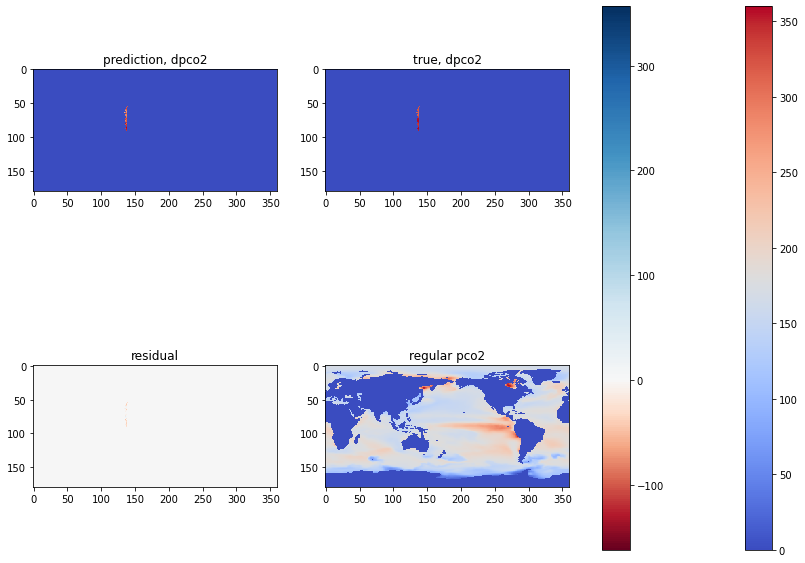

In [63]:
import matplotlib.colors as mcolors

figure, axis = plt.subplots(2, 2,figsize=(15, 10))

d = y_true - y_pred

norm = mcolors.TwoSlopeNorm(vmin=d.min(), vmax = d.max(), vcenter=0)

img=axis[0][0].imshow(np.flipud(y_pred[0]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction, dpco2")
plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(y_true[0]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true, dpco2")

diff=np.flipud(np.squeeze(y_true[0]-y_pred[0]))
img2=axis[1][0].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[1][0].set_title("residual")
plt.colorbar(img2,ax=axis)


img2=axis[1][1].imshow(np.flipud(pco2[0]),cmap="coolwarm", interpolation="nearest")
axis[1][1].set_title("regular pco2")
import matplotlib.colors as mcolors

figure, axis = plt.subplots(2, 2,figsize=(15, 10))

d = y_true - y_pred

norm = mcolors.TwoSlopeNorm(vmin=d.min(), vmax = d.max(), vcenter=0)

img=axis[0][0].imshow(np.flipud(y_pred[0]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction, dpco2")
plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(y_true[0]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true, dpco2")

diff=np.flipud(np.squeeze(y_true[0]-y_pred[0]))
img2=axis[1][0].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[1][0].set_title("residual")
plt.colorbar(img2,ax=axis)


img2=axis[1][1].imshow(np.flipud(pco2[0]),cmap="coolwarm", interpolation="nearest")
axis[1][1].set_title("regular pco2")

#plt.savefig('../../assets/transfer_nfp.png')

plt.show()
#plt.savefig('../../assets/transfer_nfp.png')

plt.show()

In [64]:
rmses = []

for i in range(421):    
    rmse = (custom_rmse(y_pred[i],y_true[i]).numpy())
    rmses.append(rmse)

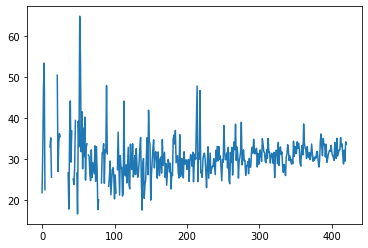

In [65]:
plt.plot(rmses)

In [68]:
#full data set

data_test,pco2_test = preprocess_images(dir_name)
predicted_frames=best_model.predict(data_test,verbose=1)
predicted_frames[pco2_test==0]=0.0

14/14 [==============================] - 2s 146ms/step


In [67]:
def inverse_scale_image(arr, df):
    """
    inverse_scale_image(arr, df):
    - inverses the pco2 scaling
    """
    
    old_min = np.nanmin(df)
    old_max = np.nanmax(df)

    y_pred = arr*(old_max-old_min)/255+old_min
    
    y_true=np.nan_to_num(df)
    y_true = np.expand_dims(y_true, axis=3)

    y_pred[y_true==0]=0
    return y_true,y_pred

In [69]:
y_true,y_pred = inverse_scale_image(predicted_frames,pco2t.pCO2.data)  

print("Full RMSE score:")
custom_rmse(y_pred,y_true)

Full RMSE score:


<tf.Tensor: shape=(), dtype=float64, numpy=122.52223317123837>

In [70]:
rmses = []

for i in range(421):    
    rmse =custom_rmse(y_pred[i],y_true[i]).numpy()
    rmses.append(rmse)

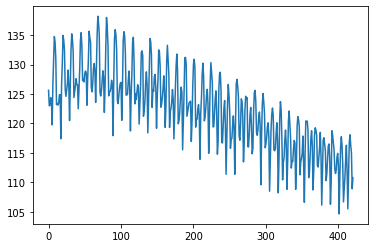

In [71]:
plt.plot(rmses)

(array([4.0000000e+00, 5.0000000e+00, 6.0000000e+00, 3.7000000e+01,
        2.8200000e+02, 1.2640000e+03, 2.6640000e+03, 4.3290000e+03,
        8.0110000e+03, 2.0045000e+04, 5.0964000e+04, 1.4170900e+05,
        3.6583900e+05, 6.3186200e+05, 9.2924100e+05, 1.0421300e+06,
        1.0978760e+06, 1.1794930e+06, 1.2281810e+06, 1.2192750e+06,
        1.1694130e+06, 1.1200840e+06, 1.1107357e+07, 1.0489530e+06,
        1.0452060e+06, 1.2975060e+06, 1.2926920e+06, 6.6258300e+05,
        2.9433000e+05, 1.6535700e+05, 7.6548000e+04, 3.7074000e+04,
        1.8013000e+04, 9.6890000e+03, 5.3770000e+03, 3.0610000e+03,
        1.9220000e+03, 1.1750000e+03, 6.6500000e+02, 3.4800000e+02,
        1.4800000e+02, 5.0000000e+01, 1.4000000e+01, 1.2000000e+01,
        3.0000000e+00, 0.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 1.0000000e+00]),
 array([-558.54243995, -533.77463925, -509.00683856, -484.23903786,
        -459.47123717, -434.70343647, -409.93563577, -385.16783508,
        

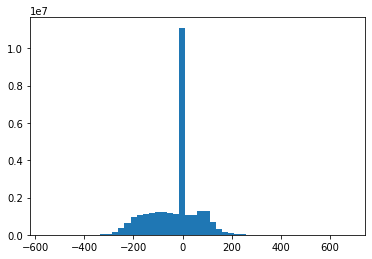

In [72]:
plt.hist(np.array(y_true-y_pred).flatten(),bins=50)

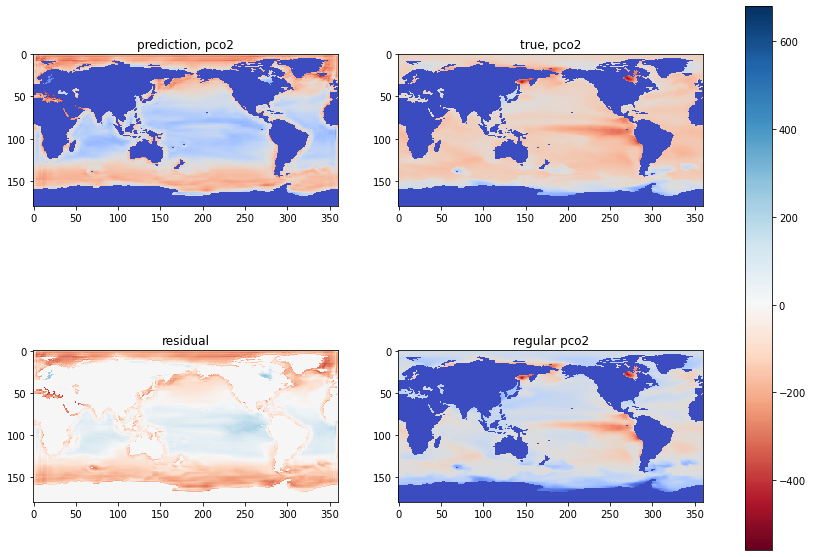

In [73]:
import matplotlib.colors as mcolors

figure, axis = plt.subplots(2, 2,figsize=(15, 10))

d = y_true - y_pred

norm = mcolors.TwoSlopeNorm(vmin=d.min(), vmax = d.max(), vcenter=0)

img=axis[0][0].imshow(np.flipud(y_pred[0]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction, pco2")
#plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(y_true[0]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true, pco2")

diff=np.flipud(np.squeeze(y_true[0]-y_pred[0]))
img2=axis[1][0].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[1][0].set_title("residual")
plt.colorbar(img2,ax=axis)


img2=axis[1][1].imshow(np.flipud(pco2[0]),cmap="coolwarm", interpolation="nearest")
axis[1][1].set_title("regular pco2")

#plt.savefig('../../assets/transfer_nfp.png')

plt.show()